In [1]:
import torch
import torch.nn as nn
# Check if we have data.zip:
import os
if not os.path.exists('data.zip'):
    # Download the data:
    !wget https://download.pytorch.org/tutorial/data.zip
if not os.path.exists('data'):
    # Unzip the data:
    !unzip data.zip
    
import sys
sys.path.append('../Code/Lecture6-NamesRNN/')
from rnn_utils import *

['data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt']
Slusarski


In [2]:
# Load the data and labels:
import numpy as np
import os
import torch

# Load the data:
x_data = []
y_data = []
for name in os.listdir('data/names'):
    if name.endswith('.txt'):
        for line in open('data/names/' + name):
            x_data.append(unicodeToAscii(line.split('\n')[0]))
            y_data.append(name.split('.')[0])

idx=0
print(x_data[idx])
print(y_data[idx])

# Convert labels to one-hot encoding:
# Get number of labels:
categories = list(set(y_data))
n_categories = len(categories)
idx_to_category = {i: category for i, category in enumerate(categories)}
print(f"{n_categories} categories (languages)")

# Convert the data to tensors:
x_data = [lineToTensor(x) for x in x_data]
print(x_data[idx].shape)
print("Now the name is encoded in a tensor of shape (name_length, 1, n_letters)")


# one-hot encode
y_data = torch.nn.functional.one_hot(
    torch.tensor([categories.index(y) for y in y_data]), 
    n_categories)
print(y_data[idx].shape)
print("Now the label is encoded in a tensor of shape (1)")
print(tensorToLine(x_data[idx]))
print(idx_to_category[y_data[idx].argmax().item()])

Abana
Spanish
18 categories (languages)
torch.Size([5, 1, 57])
Now the name is encoded in a tensor of shape (name_length, 1, n_letters)
torch.Size([18])
Now the label is encoded in a tensor of shape (1)
Abana
Spanish


In [3]:
x_train = x_data
y_train = y_data
print()

In [4]:
# x_data = np.array(x_data, dtype='object')                   
tensorToLine( x_data[idx] )
n=len(x_data)
n_train = int(0.8*n)
idx = np.random.permutation(n)-1


x_train = [x_data[i] for i in idx[:n_train]]
y_train = y_data[idx[:n_train]]

In [5]:
# # Now, let's split the data into training and validation:
# # x_data = np.array(x_data, dtype='object')

# import numpy as np

# def train_test_split(x, y, train_fraction=0.95):
#     n = len(x)
#     n_train = int(n * train_fraction)
#     idx = np.random.permutation(n)  # shuffle the indices
#     # idx = np.arange(n)

#     x_shuffled = [x[i] for i in idx]
#     y_shuffled = y[idx]

#     return x_shuffled[:n_train], y_shuffled[:n_train], x_shuffled[n_train:], y_shuffled[n_train:]

# x_train, y_train, x_test, y_test = train_test_split(x_data, y_data)

In [6]:
# Check that shuffling hasn't destroyed the data:
idx=42
print(tensorToLine(x_train[idx]))
print(idx_to_category[y_train[idx].argmax().item()])

Laar
Dutch


In [7]:
# print(y_train[idx])

In [8]:
# # Plot class frequencies in histogram:
# import matplotlib.pyplot as plt
# # sort the categories by frequency:
# sorted_idx = np.argsort(np.sum(y_train, axis=0))[::-1]
# categories = np.array(categories)[sorted_idx]
# y_data = y_data[:, sorted_idx]
# # Plot the histogram:
# plt.figure(figsize=(6, 5))
# plt.bar(categories, np.sum(y_data, axis=0))
# plt.xticks(rotation=90)
# # write the number of samples on top of the bars:
# for i, v in enumerate(np.sum(y_data, axis=0)):
#     plt.text(i, v, str(v), ha='center', va='bottom')
# plt.show()



## Bad class imbalance!

In [9]:
# Test by checking the idx'th name
idx = 944
print(categories[y_train[idx].argmax().item()])
print(''.join([all_letters[i] for i in torch.argmax(x_train[idx], axis=2)]))

Russian
Harash


In [10]:
import torch.nn as nn
DEVICE='cpu'

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(1, hidden_size)
        # self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        self.rnn = nn.RNN(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def step(self, x_in, hidden=None):
        # x_in = self.inp(x_in.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(x_in)#, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

    def forward(self, x_in, hidden=None):
        steps = x_in.size(0)
        if hidden is None:
            hidden = torch.zeros(1, 1, self.hidden_size, device=DEVICE)
        # outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            output, hidden = self.step(x_in, hidden)
            # print(output.shape)
        output = torch.nn.LogSoftmax(dim=0)(output[-1,:]).unsqueeze(0)
        return output, hidden

n_hidden = 64
rnn = SimpleRNN(n_letters, n_hidden, n_categories)



In [11]:
def train_loop(rnn, n_iters=100000, print_every=5000, plot_every=1000, learning_rate=0.005, device='cuda'):
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    
    all_losses = []
    val_losses = []
    current_loss = 0
    start = time.time()

    # print(len(x_train))

    for epoch in range(1):
        # get a validation set:
        # x_train, y_train, x_val, y_val = train_test_split(x_data, y_data, train_fraction=0.8)
        validation_idxs = np.random.permutation(len(x_train))[:int(0.2*len(x_train))]
        # get the training idxs:
        training_idxs = np.array([i for i in range(len(x_train)) if i not in validation_idxs])
        for iter in range(n_iters):
            # Choose random index
            idx = np.random.choice(training_idxs)
            
            x = x_train[idx]
            y = y_train[idx]
            ground_truth = torch.argmax(y).view(1)

            output, hidden = rnn(x)

            loss = criterion(output, ground_truth)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            current_loss += loss.item()

            if iter % print_every == 0:
                guess = categories[torch.argmax(output).item()]
                x_name = tensorToLine(x)
                gt_category = categories[ground_truth.item()]
                correct = '✓' if guess == gt_category else '✗ (%s)' % gt_category
                print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, x_name, guess, correct))

            if (iter % plot_every == 0) and (iter > 0):
                all_losses.append(current_loss / plot_every)
                current_loss = 0
                v_loss = 0
                with torch.no_grad():
                    for val_idx in validation_idxs:
                        xv = x_train[val_idx]
                        yv = y_train[val_idx]

                        output, hidden = rnn(xv)
                        v_loss += criterion(output, torch.argmax(yv).view(1))
                val_losses.append(v_loss.item() / int(0.2*len(x_train)))

    test_loss = 0#val_loss(rnn, category_lines_test, device=device)

    return all_losses, val_losses, test_loss

all_losses, val_losses, test_loss = train_loop(rnn, n_iters=int(3e5), print_every=5000, learning_rate=3e-4)

0 0% (0m 0s) 2.9868 Bagretsov / Arabic ✗ (Russian)
5000 1% (0m 10s) 3.1696 Tos / English ✗ (Spanish)
10000 3% (0m 20s) 0.7357 Tahan / Arabic ✓
15000 5% (0m 31s) 0.4095 Kettell / English ✓
20000 6% (0m 42s) 0.5726 Mawson / English ✓
25000 8% (0m 52s) 0.0580 Abarinoff / Russian ✓
30000 10% (1m 4s) 0.1786 Appleby / English ✓
35000 11% (1m 15s) 0.3192 Masanobu / Japanese ✓
40000 13% (1m 25s) 3.1392 Geroux / Arabic ✗ (French)
45000 15% (1m 35s) 0.0114 Kalitkin / Russian ✓
50000 16% (1m 45s) 0.4601 Underdown / English ✓
55000 18% (1m 55s) 0.0001 Vyalkov / Russian ✓
60000 20% (2m 4s) 1.1291 Kroger / German ✓
65000 21% (2m 14s) 0.0188 Mokhnatsky / Russian ✓
70000 23% (2m 24s) 0.6515 Moriguchi / Japanese ✓
75000 25% (2m 34s) 0.0009 Avlov / Russian ✓
80000 26% (2m 43s) 0.0001 Makhovikov / Russian ✓
85000 28% (2m 53s) 0.3995 Cove / English ✓
90000 30% (3m 3s) 2.3597 Brodbeck / English ✗ (German)
95000 31% (3m 13s) 2.2509 Hagan / Russian ✗ (English)
100000 33% (3m 23s) 0.3017 Holkin / Russian ✓
10

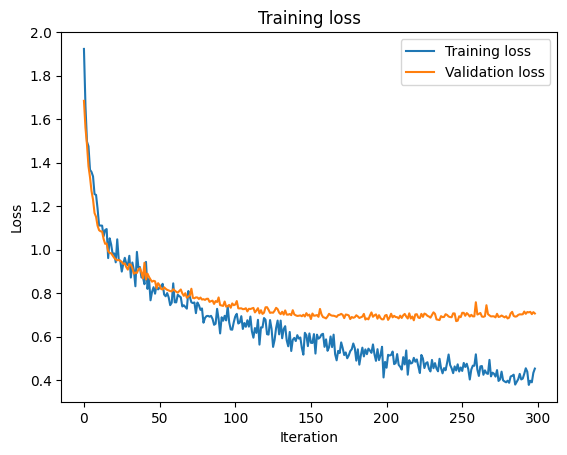

In [12]:
# Plot the loss:
import matplotlib.pyplot as plt
plt.plot(all_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()


In [13]:
# Test it out on the test set:
correct = 0
total = 0
with torch.no_grad():
    for i, (x, y) in enumerate(zip(x_test, y_test)):
        hidden = torch.zeros(1, n_hidden)
        for i in range(x.shape[0]):
            input_tensor = x[i]
            output, hidden = rnn(input_tensor, hidden)
        _, predicted = torch.max(output.data, 1)
        total += 1
        correct += (predicted == torch.argmax(torch.tensor(y)).item()).sum().item()

NameError: name 'x_test' is not defined

In [ ]:
print(f'Accuracy of the network on the {len(x_test)} validation names: {round(100 * correct / total,1)} %')

Accuracy of the network on the 1003 validation names: 46.2 %


/tmp/ipykernel_2457524/2794310624.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  category_i = torch.argmax(torch.tensor(y)).item()
/tmp/ipykernel_2457524/2794310624.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_2457524/2794310624.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


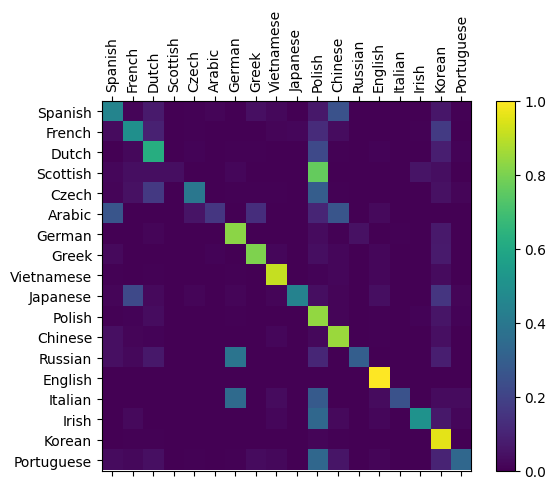

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i > n_confusion:
        break

    output, hidden = rnn(x)
    output = torch.nn.LogSoftmax(dim=0)(output[-1,:]).unsqueeze(0)

    _, predicted = torch.max(output.data, 1)
    category_i = torch.argmax(torch.tensor(y)).item()
    confusion[category_i][predicted.item()] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()